**This exercise focuses on the deep learning and classication task. The total point is 17 points (16 points + 1 bonus point).<br/>**


1.   Data loading. [0.5 point]
2.   Data preparation. [5.5 point]
3.   Training. [6 point]
4.   Loss & accuracy plot. [1 point]
5.   Test set prediction. [1 point]
6.   Evaluation/metric. [0.5 point] 
7.   Prediction of individual image. [1.5 point]

[Click here to download the dataset of this exercise](https://drive.google.com/file/d/1ChimpR2v7rg6hHaQB-dHlN6W6WSK9Suj/view?usp=share_link)



# **0. Importing Libraries**


In [1]:
import numpy as np
import pandas as pd

import os
import random
from operator import itemgetter
import copy
import time

import torch
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, Dataset, ConcatDataset
from torch.utils.data.sampler import SubsetRandomSampler
import torch.nn as nn
import torchvision.models as models
from torchvision.utils import make_grid
import torch.nn.functional as F

from sklearn.metrics import confusion_matrix, classification_report

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.image import imread
import seaborn as sns

from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings('ignore')

device= torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# **1. Data Loading**
* check some samples

**Let's take a quick look at the data. :)**

In [29]:
# set the path to dataset folder
path = r'C:\Users\tunay\OneDrive\Desktop\github_repos\MachineLearningforSciences\Datasets\flowers'

# pick one kind of flower as example
example = r'C:\Users\tunay\OneDrive\Desktop\github_repos\MachineLearningforSciences\Datasets\flowers\daisy'

Shape: (263, 320, 3)


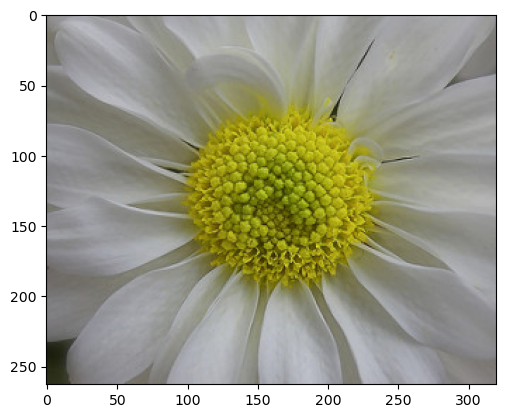

In [30]:
# show example image
img = mpimg.imread(example + '/100080576_f52e8ee070_n.jpg')
print('Shape:', img.shape)
plt.imshow(img)

**From the shape of image, we know there are 3 channels. <br/>
Let's check image channels separately**

Text(0.5, 1.0, 'Green Channel')

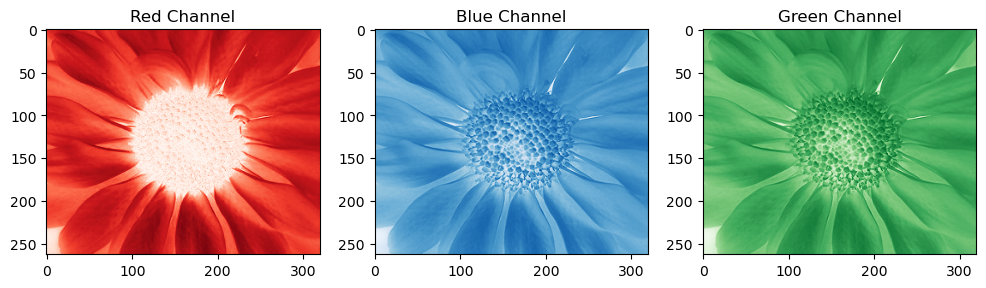

In [31]:
# [0.5 point] for this code block
# TODO: check 3 channels visually and separately 
red_channel = img[:,:,2]
blue_channel = img[:,:,1]
green_channel = img[:,:,0]

fig,axes = plt.subplots(1,3,figsize=(12,4))

axes[0].imshow(red_channel,cmap='Reds')
axes[0].set_title('Red Channel')

axes[1].imshow(blue_channel,cmap='Blues')
axes[1].set_title('Blue Channel')

axes[2].imshow(green_channel,cmap='Greens')
axes[2].set_title('Green Channel')
###

**From the image above, you can understand that they are not normalized (which is very expected), let's check the histogram of this image:**

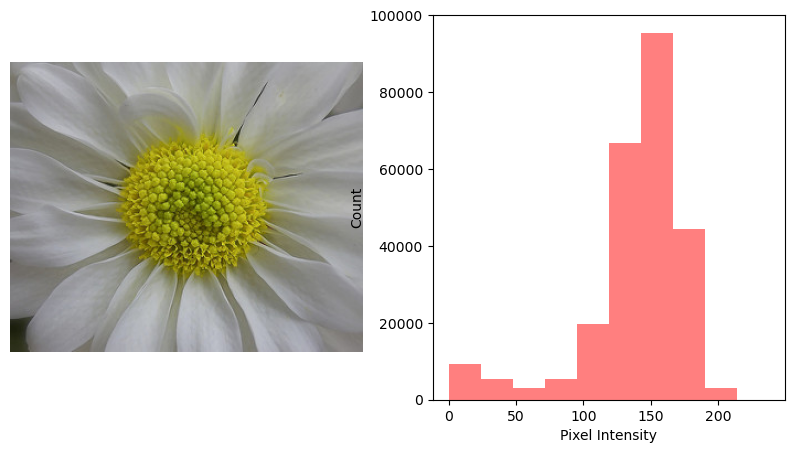

In [32]:
def plotHist(img):
    plt.figure(figsize=(10,5))
    plt.subplot(1,2,1)
    plt.imshow(img)
    plt.axis('off')
    hist = plt.subplot(1,2,2)
    hist.set_ylabel('Count')
    hist.set_xlabel('Pixel Intensity')
    plt.hist(img.flatten(), bins=10, lw=0, alpha=0.5, color='r')

plotHist(img)

# **2. Data preparation**


**Let's write the dataset transformation, including normalization.**

The "original" dataset is the original dataset, which we will split into two parts: test (20%) and training (80%).

**Bonus: besides normalization, can you try other image augmentation?**

In [33]:
transformer = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) # Resnet model architecture mean and std values
])

**pin_memory:** You know how sometimes your GPU memory shows that it’s full but you’re pretty sure that your model isn’t using that much? That overhead is called pinned memory. ie: this memory has been reserved as a type of “working allocation.”
When you enable pinned_memory in a DataLoader it “automatically puts the fetched data Tensors in pinned memory, and enables faster data transfer to CUDA-enabled GPUs”

**num_workers:** PyTorch allows loading data on multiple processes simultaneously. A good rule: ***num_worker = 4 * num_GPU***

In [34]:
# [2 point] for this code block
# define batch size
bs = 50

# TODO: create PyTorch dataset (HINT: USE torchvision.datasets.ImageFolder)
###
dataset = torchvision.datasets.ImageFolder(root=path, transform=transformer)

# TODO: define train, val, test set
###
print(f'Dataset size: {len(dataset)}')
indices = list(range(len(dataset)))
split_val = int(0.8*len(dataset))

# Shuffle 
np.random.shuffle(indices)

train_indices, val_indices, test_indices = indices[:split_val], indices[split_val:], indices[split_val:]

train_sampler = torch.utils.data.sampler.SubsetRandomSampler(train_indices)
val_sampler = torch.utils.data.sampler.SubsetRandomSampler(val_indices)
test_sampler = torch.utils.data.sampler.SubsetRandomSampler(test_indices)

# TODO: create dataloader
###
train_loader = torch.utils.data.DataLoader(dataset, batch_size=bs,sampler=train_sampler)
val_loader = torch.utils.data.DataLoader(dataset, batch_size=bs, sampler=val_sampler)
test_loader = torch.utils.data.DataLoader(dataset, batch_size=bs, sampler=test_sampler)

# check the dataset size
dataset_sizes = {
    'train': len(train_indices),
    'val': len(val_indices), 
    'test': len(test_indices),
}
print(dataset_sizes)

Dataset size: 4317
{'train': 3453, 'val': 864, 'test': 864}


**Now let's check how well we managed to normalize the data for each channel for the test, training and validation datasets:** <br/>
check the mean and standard deviation of each channal in each subset

In [27]:
# [1 point] for this code block
channels = 3

for channel in range(channels):
    for x in ['train','val','test']:
        #number of pixels in the dataset = number of all pixels in one object * number of all objects in the dataset
        first_image_shape = mpimg.imread(dataset.imgs[0][0]).shape
        num_pxl = dataset_sizes[x] * first_image_shape[0] * first_image_shape[1]
        

        data_loader = train_loader if x == 'train' else val_loader if x == 'val' else test_loader
    
        #we go through the butches and sum up the pixels of the objects, 
        #which then divide the sum by the number of all pixels to calculate the average
        total_sum = 0
        for batch, _ in data_loader:

            # TODO: YOUR CODES HERE
            total_sum += batch[:, channel, :, :].sum()
            
        mean = total_sum / num_pxl

        #we calculate the standard deviation using the formula that I indicated above
        # TODO: YOUR CODES HERE
        sum_squares = 0
        for batch, _ in data_loader:
            sum_squares += ((batch[:, channel, :, :] - mean) ** 2).sum()

        std = np.sqrt(sum_squares / num_pxl)

    
        print(f'|channel:{channel+1}| {x} - mean: {mean}, std: {std}')

|channel:1| train - mean: -0.07311272621154785, std: 0.9926618933677673
|channel:1| val - mean: -0.04650207608938217, std: 0.9904630184173584
|channel:1| test - mean: -0.04650207608938217, std: 0.9904630184173584
|channel:2| train - mean: -0.10143236815929413, std: 0.9114532470703125
|channel:2| val - mean: -0.07281459122896194, std: 0.9037123918533325
|channel:2| test - mean: -0.07281457632780075, std: 0.9037123322486877
|channel:3| train - mean: -0.2828974723815918, std: 0.9908820390701294
|channel:3| val - mean: -0.2666429579257965, std: 1.0047372579574585
|channel:3| test - mean: -0.2666429281234741, std: 1.0047372579574585


**Let's take a batch from the training dataset and see its mean and standard deviation:**

In [28]:
x, y = next(iter(train_loader))
x.mean(),  x.std()

(tensor(-0.3220), tensor(1.2629))

**Let's take a look at the pixel distribution after normalization. Compared to the distribution at the beginning, the difference is large**

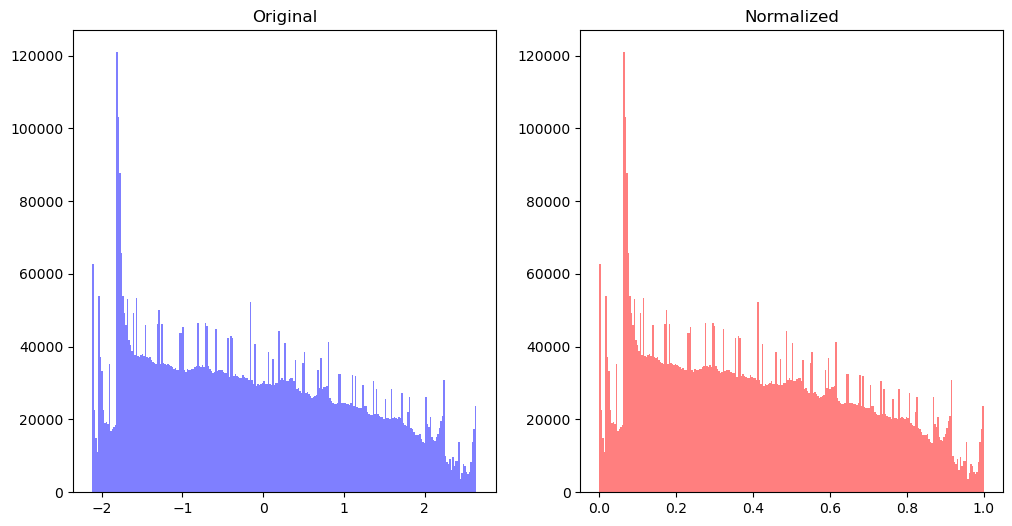

In [10]:
# [0.5 point] for this code block
# randomly pick a sample from train set
x, y = next(iter(iter(train_loader)))
# TODO: YOUR CODES HERE
x_normalized = (x - x.min()) / (x.max() - x.min())

fig, axes = plt.subplots(1, 2, figsize=(12, 6))

axes[0].hist(x.numpy().flatten(), bins=256, color='blue', alpha=0.5)
axes[0].set_title("Original")

axes[1].hist(x_normalized.flatten(), bins=256, color='red', alpha=0.5)
axes[1].set_title("Normalized")
plt.show()

**This is how we can look at our classes. There are only five of them, which is not much**

In [35]:
print('Classes:', dataset.classes)
print('Number of classes:', len(dataset.classes))

Classes: ['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']
Number of classes: 5


**Let's check how imbalanced our data is. How many samples in each class?**

In [36]:
# [0.5 point] for this code block
# TODO: YOUR CODES HERE
value_counts = []
for name in dataset.classes:
    value_count = len(os.listdir(path+"\\"+name))
    value_counts.append(value_count)
    print(f'{name} has {value_count} images.')


daisy has 764 images.
dandelion has 1052 images.
rose has 784 images.
sunflower has 733 images.
tulip has 984 images.


**Visualize the result (e.g. use bar plot to show number of samples in each class)**

<BarContainer object of 5 artists>

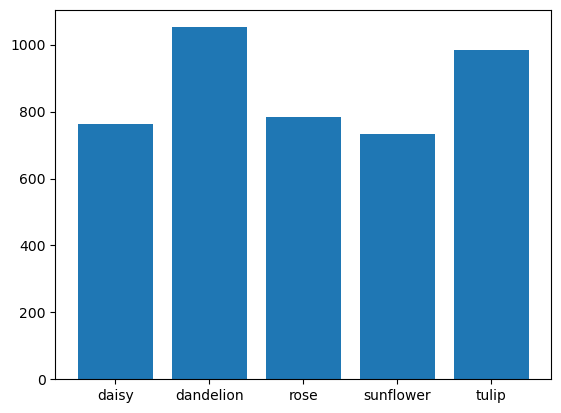

In [10]:
# [0.5 point] for this code block
# TODO: YOUR CODES HERE
plt.bar(dataset.classes, value_counts)

**Do we need to handle the imbalance? What do you think**

Even though dandelion and tulip has more images compared to sunflower, the overal data distribution across the flower types seems balanced. No need to handle imbalance. Removing the data or adding identical data to even out the dataset will be more harmful than the slight imbalance in the dataset as it is now. 

**Let's see how the images from the original dataset look like without changes:**

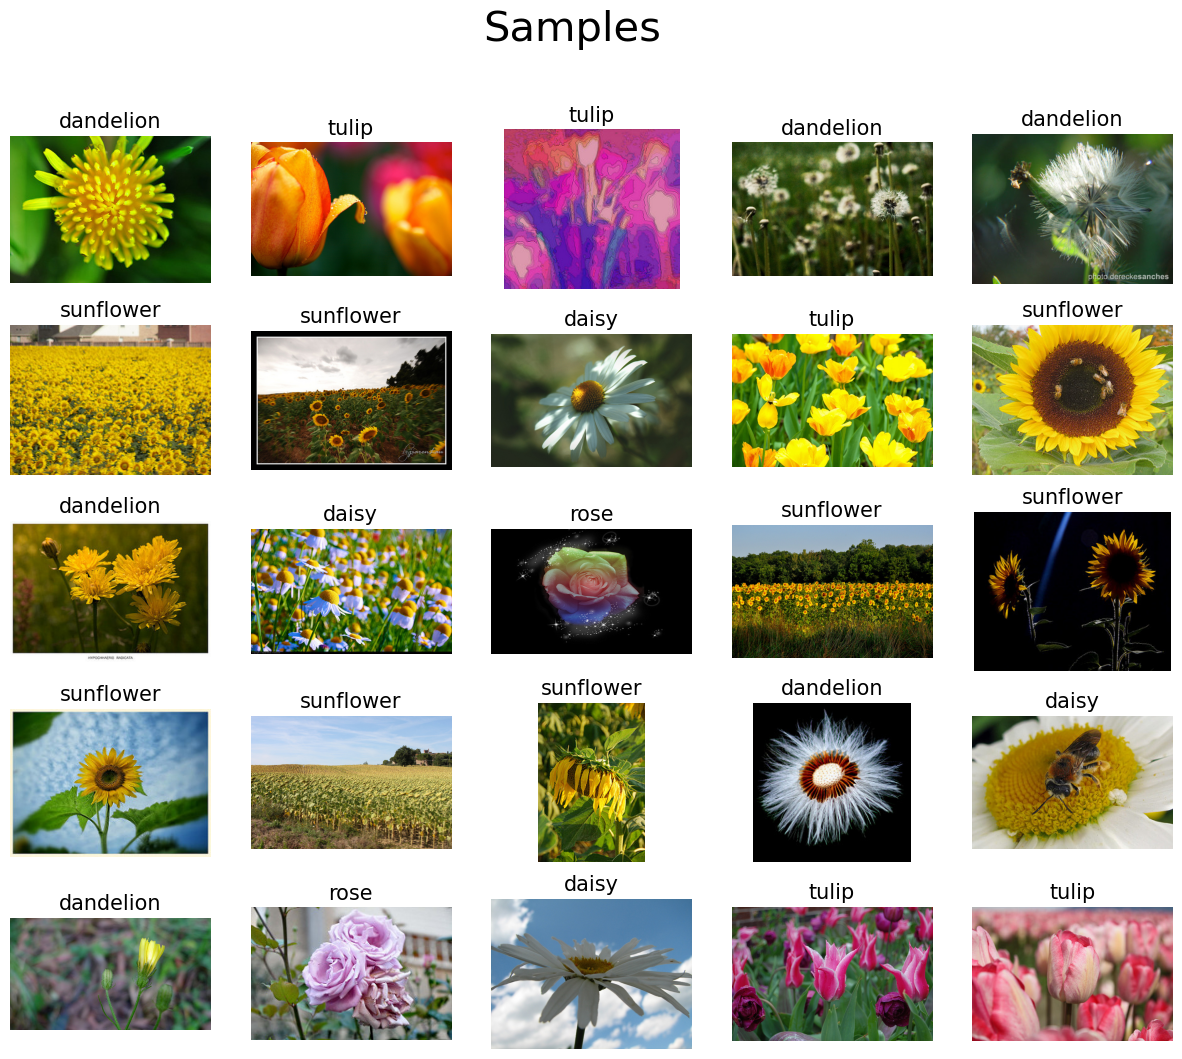

In [11]:
# Function for plotting samples
def plot_samples(samples):  
    fig, ax = plt.subplots(nrows=5, ncols=5, figsize=(15,12))
    i = 0
    for row in range(5):
         for col in range(5):
                img = mpimg.imread(samples[i][0][0])
                ax[row][col].imshow(img)
                ax[row][col].axis('off')
                ax[row][col].set_title(samples[i][1], fontsize=15)
                i+=1

rand_samples = [] 
for _ in range(25): 
    classes = random.choice(dataset.classes)
    rand_samples.append([random.sample([os.path.join(path+'/'+classes, filename) for filename in os.listdir(path+'/'+classes)], 1), classes]) 
rand_samples[0]
plot_samples(rand_samples)
plt.suptitle('Samples', fontsize=30)
plt.show()

**And this is how images with augmentation look like**

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


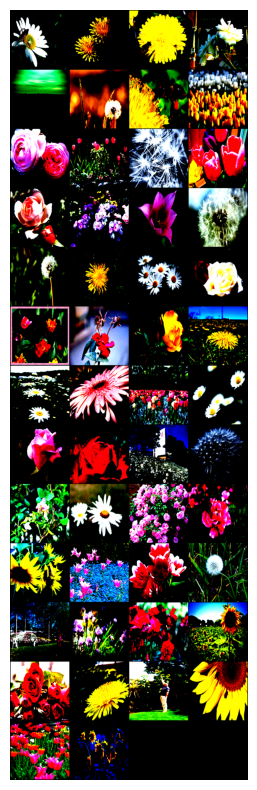

In [32]:
# [1 point] for this code block
# Breaks after one iteration because the function prints out the entire dataset.
def show_batch(dl):
    for images, labels in dl:
        # Create a grid of images
        grid = torchvision.utils.make_grid(images, nrow=4)
        
        # Convert the tensor to numpy array
        np_grid = grid.numpy()
        
        # Transpose the dimensions for matplotlib
        np_grid = np.transpose(np_grid, (1, 2, 0))
        
        # Display the images
        plt.figure(figsize=(10, 10))
        plt.imshow(np_grid)
        plt.axis('off')
        plt.show()
        break

show_batch(train_loader)

# 3. Training and Test

In order not to count the accuracy many times, we write the function to compute the classification accuracy between prediction and ground truth.

In [13]:
# [1 point] for this code block
def accuracy(outputs, labels):
    # TODO: YOUR CODES HERE
    output_count = len(outputs)
    correct_count = 0
    for idx, output in enumerate(outputs):
        if output == labels[idx]:
            correct_count +1
    
    return correct_count / output_count

**This is where we will record the history of learning, so that we can make visualization later. We need visualization to evaluate learning, for example, overfitting or underfitting. Of course, we can analyze with numbers, but it is much easier to perceive information visually**

In [14]:
#save the losses for further visualization
losses = {'train':[], 'val':[]}
accuracies = {'train':[], 'val':[]}
lr = []

### Train function structure:
TODO list:
* define loss, optimizer
* set different behavior of model for train and validation step
* keep the record of loss and accuracy 
* keep the best model

In [48]:
def train(epochs, model, learning_rate=0.001):
    model.to(device)  
    
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    criterion = torch.nn.CrossEntropyLoss()
    
    since = time.time()
    best_model = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    train_losses = []
    val_losses = []
    train_accs = []
    val_accs = []

    for epoch in range(epochs):
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
                loader = train_loader
            else:
                model.eval()
                loader = val_loader
      
            running_loss = 0.0
            running_corrects = 0.0
            
            for inputs, labels in loader:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase=='train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    
                if phase == 'train':
                    loss.backward()
                    optimizer.step()
                    
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
    
            epoch_loss = running_loss / len(loader.dataset)
            epoch_acc = running_corrects.double() / len(loader.dataset)

            if phase == 'train':
                train_losses.append(epoch_loss)
                train_accs.append(epoch_acc.item())
            else:
                val_losses.append(epoch_loss)
                val_accs.append(epoch_acc.item())

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model = copy.deepcopy(model.state_dict())

    time_elapsed = time.time() - since
    print('CLASSIFIER TRAINING TIME {}m {}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('==' * 31)

    model.load_state_dict(best_model)

    return model, train_losses, val_losses, train_accs, val_accs

# MODELS

**Let's use pretrained ResNet model**

In [16]:
resnet34 = torchvision.models.resnet34(pretrained=True)

for param in resnet34.parameters():
    param.grad_requires = False

# replace the last layer as a new classifier, which is suitable for our data
num_classes=5
resnet34.fc = nn.Linear(resnet34.fc.in_features, num_classes)

**Launching training**

In [50]:
epochs = 10

model = train(epochs=epochs, model=resnet34)

train Loss: 0.5750 Acc: 0.5997
val Loss: 0.1774 Acc: 0.1464
train Loss: 0.5618 Acc: 0.6055
val Loss: 0.1328 Acc: 0.1568
train Loss: 0.3166 Acc: 0.6857
val Loss: 0.1245 Acc: 0.1568
train Loss: 0.3318 Acc: 0.6794
val Loss: 0.0888 Acc: 0.1672
train Loss: 0.1941 Acc: 0.7318
val Loss: 0.0815 Acc: 0.1714
train Loss: 0.1592 Acc: 0.7415
val Loss: 0.2522 Acc: 0.1427
train Loss: 0.3194 Acc: 0.6880
val Loss: 0.1099 Acc: 0.1647
train Loss: 0.1551 Acc: 0.7457
val Loss: 0.1495 Acc: 0.1568
train Loss: 0.4080 Acc: 0.6521
val Loss: 0.1055 Acc: 0.1647
train Loss: 0.2487 Acc: 0.7118
val Loss: 0.1180 Acc: 0.1617
CLASSIFIER TRAINING TIME 38.0m 20.43248677253723s


In [51]:
# Save the model for later use.
torch.save(resnet34.state_dict(), 'lab7_model.pth')

# 4. Loss and Accuracy Plots

**Visualize the accuracy and loss of train and validation set during the model learning**

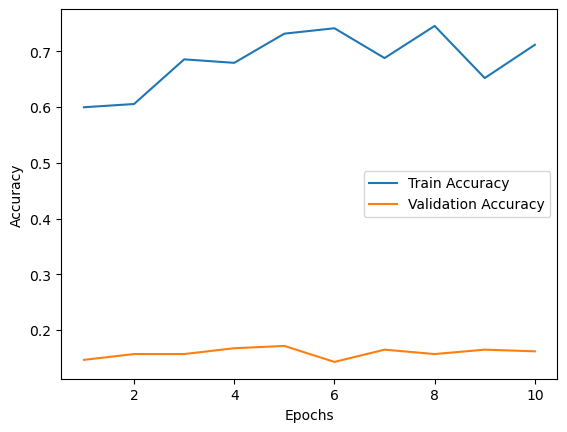

In [52]:
# [0.5 point] for this code block
# plot of train and validation accuracy, vs epoch number
# TODO: YOUR CODES HERE 

def train_val_accuracy_plot(train_acc,val_acc,epochs=10):

    epochs = range(1, len(train_acc) + 1)
    plt.plot(epochs, train_acc, label = 'Train Accuracy')
    plt.plot(epochs, val_acc, label = 'Validation Accuracy')

    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

train_val_accuracy_plot(model[3],model[4])

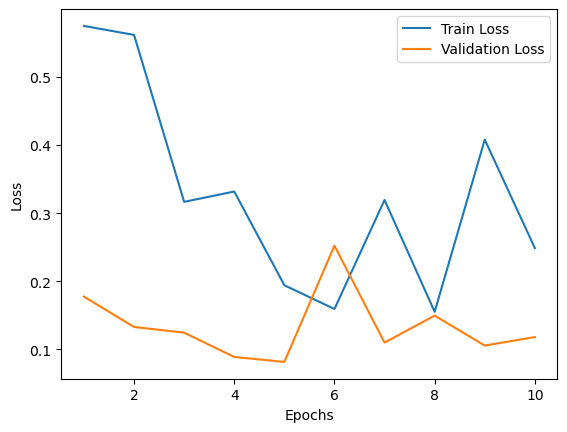

In [55]:
# [0.5 point] for this code block
#plot of train and validation loss, vs epoch number
# TODO: YOUR CODES HERE 

def train_val_loss_plot(train_loss, val_loss,epochs=10):
        
    epochs = range(1, len(train_loss) + 1)
    plt.plot(epochs, train_loss, label = 'Train Loss')
    plt.plot(epochs, val_loss, label = 'Validation Loss')

    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

train_val_loss_plot(model[1],model[2])

# 5. Test set predictions

**These functions will help us when calculating the accuracy**

In [18]:
@torch.no_grad()
def test_predict(model, test_loader):
    model.eval()
    
    test_preds = []
    test_labels = []
    
    for batch_x, batch_y in test_loader:

        outputs = model(batch_x)

        _, predicted = torch.max(outputs, dim=1)
        predicted = predicted.tolist()
        batch_y = batch_y.tolist()
        test_preds.extend(predicted)
        test_labels.extend(batch_y)
    

    test_preds = torch.tensor(test_preds)
    test_labels = torch.tensor(test_labels)
    
    return test_preds, test_labels

**What's the loss and accuracy of the test set?**

In [38]:

model_path = r'C:\Users\tunay\OneDrive\Desktop\github_repos\MachineLearningforSciences\Labs\lab7_model.pth'
my_model = torch.load(model_path)

In [39]:
model=resnet34
model.to(device)
preds,labels = test_predict(model, test_loader)

# 6. Metrics

In [40]:
report = classification_report(labels, preds,
                               output_dict=True,
                               target_names=dataset.classes)
report_df = pd.DataFrame(report).transpose()

In [41]:
pd.set_option("display.max_rows", None)
report_df.head(134)

,precision,recall,f1-score,support
daisy,0.043478,0.020270,0.027650,148.000000
dandelion,0.333333,0.041860,0.074380,215.000000
rose,0.123457,0.066667,0.086580,150.000000
sunflower,0.025641,0.006061,0.009804,165.000000
tulip,0.200617,0.698925,0.311751,186.000000
accuracy,0.177083,0.177083,0.177083,0.177083
macro avg,0.145305,0.166757,0.102033,864.000000
weighted avg,0.159914,0.177083,0.107262,864.000000


In [42]:
from sklearn.metrics import confusion_matrix

print(confusion_matrix(labels,preds))

[[  3  10  18   4 113]
 [  2   9  24  22 158]
 [ 32   5  10   4  99]
 [  8   1   7   1 148]
 [ 24   2  22   8 130]]


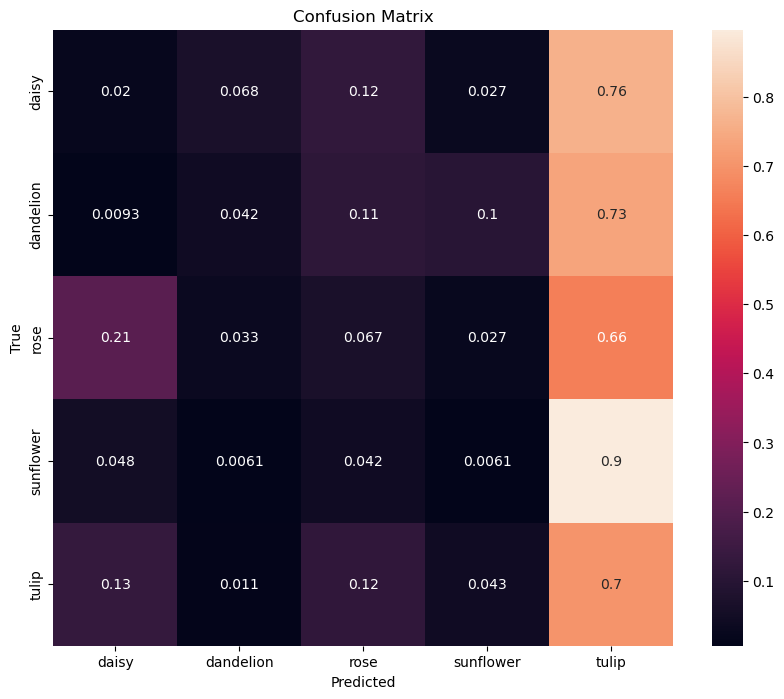

In [45]:
def plot_confusion_matrix(y_true, y_pred, classes):
    cm = confusion_matrix(y_true, y_pred)
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()
class_names = dataset.classes

# Plot the confusion matrix
plot_confusion_matrix(labels, preds, class_names)

# 7. Predictions of individual images in test set

**The function below will normalize the image back to its original. It simply multiplies the tensor by the standard deviation and adds the mean**

In [46]:
def norm_out(img):
    
    img = img.permute(1,2,0)
    mean = torch.FloatTensor([0.4124234616756439, 0.3674212694168091, 0.2578217089176178])
    std = torch.FloatTensor([0.3268945515155792, 0.29282665252685547, 0.29053378105163574])
    
    img = img*std + mean
        
    return np.clip(img,0,1)

In [ ]:
# [1.5 point] for this code block
fig, ax = plt.subplots(figsize=(8,12), ncols=2, nrows=4)
num_of_img = 4
for row in range(num_of_img):
    # randomly pick an example from test set
    # TODO: YOUR CODES HERE 
    img,label = 
    
    # get the prediction
    # TODO: YOUR CODES HERE 
    pred = 
    
    # plot the image and check the prediction



***I hope you enjoyed it and found something new for yourself!* <br/>
*For improvement, what do you think can be changed and what can be removed?*** <br/>
how about batch size? model? unfreeze parameters? augmentation? <br/>
[1 bonus point] for the answer